## Objective:
- Fit a One vs All classifier for for different types of variable stars
- Use several different classifier methods: Random Forest, Decision Tree, Logistic Regression, Naive Bayes
- Create a comparision table for different classifiers and labels. Compare using metrics like accuracy, precision and recall

In [1]:
#Load libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Complete features and label table from Xiadian's website

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('Labeled_data.txt', header=None, delim_whitespace=True, skiprows=36) # extract data
labeled_data.columns = header_pd.iloc[:,3]
labeled_data.head()
label = labeled_data.Type.unique()
label = np.delete(label, np.where(label == 'CEPII')) # CEPII has very few samples so we ignore it
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'Mira' 'RRc' 'CEP']


## Import features extracted from light curves
These features are caluclated on 1000 light curves of each variable type. The light curves are imported from variables.cn:88/
Feature list
- mean : mean of the light curve
- wmean : weight mean of the light curve
- MAD : deviation about the median
- IQR : inter quartile percentile of the light curve
- f60 : 60 percentile  of light curve
- f70 : 70 percentile of the light curve
- f80 : 80 percentile of the light curve
- f90 : 90 percentile of the light curve
- skew : skewness of the light curve
- kurtosis : kurtosis of the light curve
- welsk_k, welsh_j : welsh and staton J and K statistics of the light curve
- g_ : g band filter
- r_ : r band filter

In [3]:
df = pd.read_csv('features10000.csv', header=None, skiprows=1)
header = pd.read_csv('features10000.csv', header=None, nrows=1)
df.columns = header.iloc[0]

In [4]:
df.head()

,sourceid,ID,RAdeg,DEdeg,g_mean,g_wmean,g_MAD,g_IQR,g_f60,g_f70,...,r_IQR,r_f60,r_f70,r_f80,r_f90,r_skew,r_kurtosis,r_welsh_J,r_welsh_K,Type
0,1.0,ZTFJ000000.13+620605.8,0.000566,62.101631,17.994656,17.992102,0.034,0.07000,0.0820,0.10000,...,0.05125,0.0580,0.06655,0.0797,0.09370,0.105202,-0.632720,40.723268,1678.291273,BYDra
1,2.0,ZTFJ000000.14+721413.7,0.000620,72.237174,19.619402,19.579923,0.111,0.22650,0.2850,0.35950,...,0.22750,0.2712,0.30765,0.3614,0.44115,0.334634,-0.775188,258.579275,3360.702573,EW
2,3.0,ZTFJ000000.19+320847.2,0.000795,32.146449,15.313984,15.313984,0.072,0.14200,0.1580,0.18300,...,0.12600,0.1470,0.16080,0.1760,0.18860,-0.212606,-1.485137,171.745322,891.052032,EW
3,4.0,ZTFJ000000.26+311206.3,0.001085,31.201756,16.353295,16.353295,0.077,0.14900,0.1710,0.18700,...,0.10200,0.1322,0.15980,0.1946,0.20560,0.418285,-1.009552,202.025570,966.503331,EW
4,6.0,ZTFJ000000.30+233400.5,0.001249,23.566828,17.892283,17.878715,0.102,0.18975,0.2526,0.28225,...,0.22900,0.2700,0.29620,0.3132,0.33620,0.158998,-1.484462,253.787215,1019.579800,EW


In [5]:
# Drop rows with Blank values
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

In [6]:
# get all unique labels
label = df.Type.unique()
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'RRc' 'Mira' 'CEP']


<AxesSubplot:xlabel='Type', ylabel='Count'>

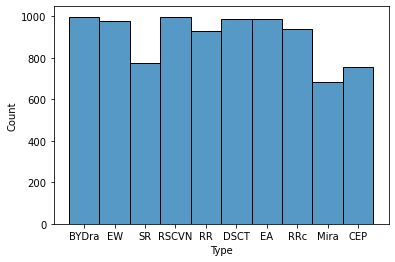

In [7]:
# Plot histogram of variable types in the dataset
import seaborn as sns
sns.histplot(data=df, x=df.Type)

## Various functions to create multiple classifiers

In [8]:
def multiple_to_2labels(df,variable_type):
    """
    converts multiple labels for diffrent variable types to only two labels for one vs all classifier.
    Returns 2 data frames: 
    1. Original data frame with new labels. 
    2. Dataframe with equal candidates of the two classes.
    """
    OneClass = variable_type
    df0 = df.copy()
    df0.loc[df0.Type != OneClass,'Type'] = 'Other'
    df1 = df0[df0.Type == 'Other']
    df2 = df0[df0.Type == OneClass]

    df3 = df1.sample(n=1000, random_state=1) # balance data type by only selecting 1000 of other type
    frames = [df2,df3]
    df_onevsall = pd.concat(frames)
    return df0, df_onevsall

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def preprocess_data(df):
    """
    Preprocess data for one vs all classifier and split it to train/test data
    """
    # Map string labels to numbers
    label = df.Type

    le = preprocessing.LabelEncoder()
    le.fit(label)

    # Drop columns that are not features
    X = df
    # Encode labels to form y labels
    y = le.transform(df.Type)

    # Split dataset into training set and test set
    X_tr, X_ts, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
    X_train = X_tr.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    X_test = X_ts.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    return X_train, X_test, y_train, y_test
    

In [10]:

from sklearn import metrics
# from sklearn.metrics import confusion_matrix
def oneVSall_classiffier(name,model,X_train, X_test, y_train, y_test):
    """
    Train Classifier using train dataset. Calculate classifier metrics using test dataset
    """
    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)

    # Predict test data output
    y_pred = clf.predict(X_test)
    
    # Estimate model performance on test data
    if name == "Isolation Forest":
        one_index = np.where(y_pred==1)
        y_pred[one_index] = 1
        negone_index = np.where(y_pred==-1)
        y_pred[negone_index] = 0
    accuracy = metrics.accuracy_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
                                      
    return clf, accuracy, precision, recall, confusion

## Train and Compare Classifiers

In [11]:
# list of classification methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier

names = ["XG Boost","Random Forest", "Decision Tree", "Logistic Regression", "Naive Bayes", "Isolation Forest"]

classifiers = [
    XGBClassifier(),
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier(criterion="gini", max_depth=3),
    LogisticRegression(max_iter = 500),
    GaussianNB(),
    IsolationForest()]


In [12]:
# Run loop to train all classifiers and collect metrics in a dataframe
accuracy ={}
precision = {}
recall = {}
confusion ={}

# create comparision dataframe
header = pd.MultiIndex.from_product([names,
                                     ['accuracy','precision','recall']],
                                    names=['classifier','metric'])
index_label = label
pd_comparison = pd.DataFrame(data=None, index=index_label, columns=header, dtype=None, copy=False)

# train models and collect metrics on test data
for name, clf in zip(names, classifiers): # loop over different classifiers
    print(name)
    accuracy[name] = {}
    precision[name] = {}
    recall[name] = {}
    confusion[name] ={}
    for variable_type in label: #loop over different types of variable stars
        print(variable_type)
        df0, df_onevsall = multiple_to_2labels(df,variable_type)
        X_train, X_test, y_train, y_test = preprocess_data(df0)
        clf, accuracy[name][variable_type],precision[name][variable_type],recall[name][variable_type], confusion[name][variable_type] = oneVSall_classiffier(name,clf,X_train, X_test, y_train, y_test)
    pd_comparison.loc[:,(name,'accuracy')] = list(accuracy[name].values())
    pd_comparison.loc[:,(name,'precision')] = list(precision[name].values())
    pd_comparison.loc[:,(name,'recall')] = list(recall[name].values())

XG Boost
BYDra
[22:23:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


EW
[22:23:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


SR
[22:23:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


RSCVN
[22:23:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


RR
[22:23:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


DSCT
[22:23:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


EA
[22:23:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


RRc
[22:23:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Mira
[22:23:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CEP
[22:23:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Random Forest
BYDra
EW
SR
RSCVN
RR
DSCT
EA
RRc
Mira
CEP
Decision Tree
BYDra
EW
SR
RSCVN
RR
DSCT
EA
RRc
Mira
CEP
Logistic Regression
BYDra


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


EW


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SR


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RSCVN


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RR


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DSCT
EA


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RRc


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mira


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CEP


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naive Bayes
BYDra
EW
SR
RSCVN
RR
DSCT
EA
RRc
Mira
CEP
Isolation Forest
BYDra
EW
SR
RSCVN
RR
DSCT
EA
RRc
Mira
CEP


In [13]:
# print the comparision table
pd_comparison.head(20)

classifier  XG Boost                     Random Forest                      \
metric      accuracy precision    recall      accuracy precision    recall   
BYDra       0.902511  0.925764  0.968037      0.897341  0.905653  0.987094   
EW          0.938331  0.952497  0.979132      0.940177  0.947970  0.987680   
SR          0.958641  0.893750  0.600840      0.954210  0.903846  0.451923   
RSCVN       0.903988  0.624242  0.342193      0.903250  0.648148  0.238095   
RR          0.968981  0.871698  0.822064      0.957903  0.832599  0.713208   
DSCT        0.926514  0.941551  0.978512      0.920606  0.930078  0.985106   
EA          0.983383  0.988396  0.992923      0.975997  0.985173  0.988021   
RRc         0.963072  0.890196  0.759197      0.954948  0.875000  0.665493   
Mira        0.997415  0.998805  0.998407      0.996307  0.997609  0.998404   
CEP         0.971935  0.976209  0.993543      0.960118  0.964595  0.992713   

classifier Decision Tree                     Logistic Regression            \
metric          accuracy precision    recall            accuracy precision   
BYDra           0.893648  0.893648  1.000000            0.886263  0.889632   
EW              0.887001  0.887288  0.999584            0.888479  0.898605   
SR              0.922083  0.000000  0.000000            0.943870  0.795775   
RSCVN           0.889586  0.666667  0.070968            0.889217  0.428571   
RR              0.936854  0.863636  0.469965            0.944978  0.770563   
DSCT            0.896233  0.908745  0.983135            0.888479  0.900385   
EA              0.972304  0.982217  0.986705            0.973412  0.981474   
RRc             0.939808  0.890511  0.451852            0.942024  0.785714   
Mira            0.997415  0.998010  0.999203            0.998523  0.999603   
CEP             0.922083  0.933156  0.985955            0.941285  0.953870   

classifier           Naive Bayes                     Isolation Forest  \
metric        recall    accuracy precision    recall         accuracy   
BYDra       0.995426    0.538405  0.988206  0.486924         0.804653   
EW          0.986347    0.279542  0.995960  0.201884         0.793575   
SR          0.478814    0.250369  0.097670  0.931624         0.178360   
RSCVN       0.030303    0.491507  0.165031  0.943860         0.200886   
RR          0.649635    0.704579  0.263747  0.965870         0.197932   
DSCT        0.981963    0.404727  0.989336  0.342494         0.779911   
EA          0.988801    0.425406  0.991908  0.356460         0.817578   
RRc         0.617544    0.675037  0.236220  0.974729         0.191285   
Mira        0.998810    0.986337  0.999594  0.985594         0.983013   
CEP         0.983474    0.516617  0.985750  0.476499         0.826809   

classifier                      
metric     precision    recall  
BYDra       0.885540  0.897605  
EW          0.877501  0.892442  
SR          0.093213  0.970213  
RSCVN       0.118271  0.993151  
RR          0.118078  0.979730  
DSCT        0.875207  0.877390  
EA          0.892828  0.904624  
RRc         0.106531  0.996183  
Mira        0.999593  0.982007  
CEP         0.908462  0.901494